# BC5

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc5


## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
import ta

warnings.filterwarnings('ignore')



In [2]:
from functools import reduce

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [4]:
from matplotlib.colors import LinearSegmentedColormap


In [5]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


### Variables

In [6]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data_updated/'
DATA_OUT_PATH = '../../data_out/'


In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

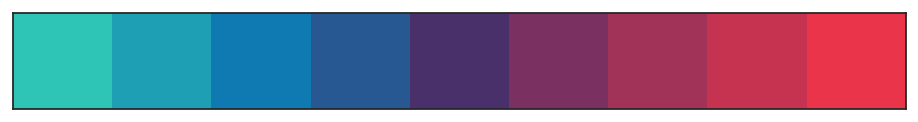

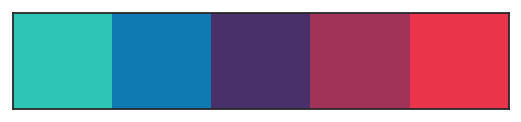

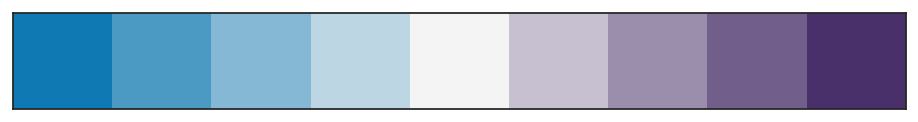

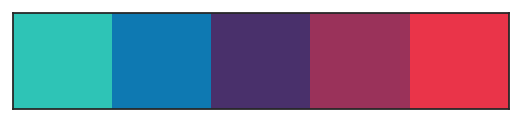

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Get Data

In [10]:
START_DATE = '2017-05-09'
END_DATE = '2022-05-08'
END_DATE_ = '2022-05-09'

In [11]:
## Gold prices as proxy for risk-aversion
stock_symbol = "VIX"
stock_data = pdr.get_data_yahoo(stock_symbol, start=START_DATE, end=END_DATE_)
stock_data = stock_data.reset_index()

[*********************100%***********************]  1 of 1 completed


### Twitter

In [12]:
import tweepy

In [13]:
## Get keys
tk = pd.read_csv('../../../twitter.csv')#.set_index('label')

apiKey = tk.loc[tk['label']=='api']['key'].values[0]
apiSecret = tk.loc[tk['label']=='apisecret']['key'].values[0]
accessToken = tk.loc[tk['label']=='accesstoken']['key'].values[0]
accessTokenSecret = tk.loc[tk['label']=='accesstokensecret']['key'].values[0]


In [14]:
# Set authentication and access token
auth = tweepy.OAuthHandler(apiKey, apiSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

noOfTweet = 1000


In [18]:
def get_tweets(sym):
    tweets = tweepy.Cursor(api.search_tweets, q=sym, tweet_mode='extended', lang='en').items(noOfTweet)
    tweet_list = []
    for t in tweets:
        if not "Bot" in t.author.name :
            tweet_list.append(t.full_text)
            
    return tweet_list

In [164]:
tweet_list = get_tweets(stock_symbol)

In [165]:
# tweet_list

In [166]:
tweet_list_ = tweet_list.copy()

In [167]:
df_tweet = pd.DataFrame(tweet_list)
df_tweet.to_csv('tweet_sample.csv', index=False)

### yfinance

In [50]:
date_interval = 365
END_DATE = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
START_DATE = (datetime.today() + timedelta(days=-date_interval)).strftime('%Y-%m-%d')

print(START_DATE, END_DATE)

2021-05-16 2022-05-17


In [93]:
def get_findata(sym, start_date, end_date):
    df_ = pdr.get_data_yahoo(sym, start=start_date, end=end_date)
    df_ = df_.reset_index().set_index('Date').asfreq('d')
    df_['DateCol'] = df_.index
    df_.fillna(method='ffill', inplace=True)    
    return df_

In [94]:
gold_data = get_findata('GC=F', START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed


In [95]:
gold_data.head(15)

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-17,1849.900024,1867.500000,1847.199951,1867.500000,1867.500000,13.0,2021-05-17
2021-05-18,1870.500000,1870.500000,1867.800049,1867.800049,1867.800049,3.0,2021-05-18
2021-05-19,1866.400024,1884.900024,1863.599976,1881.300049,1881.300049,348.0,2021-05-19
2021-05-20,1865.500000,1885.000000,1864.800049,1881.800049,1881.800049,85.0,2021-05-20
2021-05-21,1872.099976,1876.699951,1872.099976,1876.699951,1876.699951,5.0,2021-05-21
2021-05-22,1872.099976,1876.699951,1872.099976,1876.699951,1876.699951,5.0,2021-05-22
2021-05-23,1872.099976,1876.699951,1872.099976,1876.699951,1876.699951,5.0,2021-05-23
2021-05-24,1882.099976,1884.599976,1882.099976,1884.599976,1884.599976,39.0,2021-05-24
2021-05-25,1882.500000,1898.099976,1882.500000,1898.099976,1898.099976,56.0,2021-05-25


In [151]:
symbol = 'GOOG'
fin_data = get_findata(symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [152]:
fin_data

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-17,2309.320068,2323.340088,2295.000000,2321.409912,2321.409912,992100.0,2021-05-17
2021-05-18,2336.906006,2343.149902,2303.159912,2303.429932,2303.429932,865100.0,2021-05-18
2021-05-19,2264.399902,2316.760010,2263.520020,2308.709961,2308.709961,967500.0,2021-05-19
2021-05-20,2328.040039,2360.340088,2321.090088,2356.090088,2356.090088,1191600.0,2021-05-20
2021-05-21,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-21
...,...,...,...,...,...,...,...
2022-05-12,2238.760010,2297.129883,2202.270020,2263.219971,2263.219971,2073200.0,2022-05-12
2022-05-13,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-13
2022-05-14,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-14


In [153]:
wixinfo = yf.Ticker(symbol).info


In [159]:
yf.Ticker('GOOGL').info
# marketcap
# industry
# sector

{'zip': '94043',
 'sector': 'Communication Services',
 'fullTimeEmployees': 163906,
 'longBusinessSummary': 'Alphabet Inc. provides various products and platforms in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment offers products and services, including ads, Android, Chrome, hardware, Gmail, Google Drive, Google Maps, Google Photos, Google Play, Search, and YouTube. It is also involved in the sale of apps and in-app purchases and digital content in the Google Play store; and Fitbit wearable devices, Google Nest home products, Pixel phones, and other devices, as well as in the provision of YouTube non-advertising services. The Google Cloud segment offers infrastructure, platform, and other services; Google Workspace that include cloud-based collaboration tools for enterprises, such as Gmail, Docs, Drive, Calendar, and Meet; and other se

In [154]:
wixinfo

{'zip': '94043',
 'sector': 'Communication Services',
 'fullTimeEmployees': 163906,
 'longBusinessSummary': 'Alphabet Inc. provides various products and platforms in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment offers products and services, including ads, Android, Chrome, hardware, Gmail, Google Drive, Google Maps, Google Photos, Google Play, Search, and YouTube. It is also involved in the sale of apps and in-app purchases and digital content in the Google Play store; and Fitbit wearable devices, Google Nest home products, Pixel phones, and other devices, as well as in the provision of YouTube non-advertising services. The Google Cloud segment offers infrastructure, platform, and other services; Google Workspace that include cloud-based collaboration tools for enterprises, such as Gmail, Docs, Drive, Calendar, and Meet; and other se

In [145]:
with open('dash/data/wix.json', 'w') as fp:
    json.dump(wixinfo, fp)


In [146]:
json_object = {}
with open('dash/data/wix.json', 'r') as fp:
    json_object = json.load(fp)
json_object


{'companyOfficers': [],
 'twitter': '"https://twitter.com/ethereum"',
 'name': 'Ethereum',
 'startDate': 1438905600,
 'description': 'Ethereum (ETH) is a cryptocurrency . Users are able to generate ETH through the process of mining. Ethereum has a current supply of 120,807,342.499. The last known price of Ethereum is 2,032.97470184 USD and is down -2.98 over the last 24 hours. It is currently trading on 5717 active market(s) with $21,463,172,594.81 traded over the last 24 hours. More information can be found at https://www.ethereum.org/.',
 'maxAge': 1,
 'exchange': 'CCC',
 'shortName': 'Ethereum USD',
 'exchangeTimezoneName': 'UTC',
 'exchangeTimezoneShortName': 'UTC',
 'isEsgPopulated': False,
 'gmtOffSetMilliseconds': '0',
 'quoteType': 'CRYPTOCURRENCY',
 'symbol': 'ETH-USD',
 'messageBoardId': 'finmb_ETH_CCC',
 'market': 'ccc_market',
 'previousClose': 2022.5414,
 'regularMarketOpen': 2022.5414,
 'twoHundredDayAverage': 3336.939,
 'trailingAnnualDividendYield': None,
 'payoutRatio'

In [150]:
'longName' in json_object.keys() 

False

## Models

In [97]:
def shift_split_data(df_, target_col, fitsize=7):
    df = df_.copy()
    ## Date_Y is the date being predicted
    ## The corresponding Date_X of the same row is the previous date
    df['Date_Y'] = df['DateCol']+ pd.DateOffset(days=1) 
    df['Y'] = df[target_col].shift(periods=-1)
    df.rename(columns={'DateCol':'Date_X'}, inplace=True)
    
    ## last fitsize days to fit for prediction on the next day
    df_fit = df.iloc[-fitsize:]
    
    return df_fit
    
    

In [98]:
fin_data

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-17,221.279999,225.740005,213.119995,224.779999,224.779999,1762600.0,2021-05-17
2021-05-18,227.705002,233.660004,224.649994,226.580002,226.580002,1174300.0,2021-05-18
2021-05-19,221.020004,235.800003,218.500000,234.669998,234.669998,1068600.0,2021-05-19
2021-05-20,236.660004,250.570007,236.500000,247.570007,247.570007,1317200.0,2021-05-20
2021-05-21,248.889999,252.095001,243.000000,248.160004,248.160004,958900.0,2021-05-21
...,...,...,...,...,...,...,...
2022-05-12,57.959999,64.430000,56.240002,63.279999,63.279999,3061400.0,2022-05-12
2022-05-13,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0,2022-05-13
2022-05-14,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0,2022-05-14


In [100]:
split_fin_data = shift_split_data(fin_data, 'Close')
split_fin_data

,Open,High,Low,Close,Adj Close,Volume,Date_X,Date_Y,Y
Date,,,,,,,,,
2022-05-10,68.010002,70.269997,63.099998,64.570000,64.570000,1435100.0,2022-05-10,2022-05-11,58.349998
2022-05-11,63.630001,64.430000,57.810001,58.349998,58.349998,2009200.0,2022-05-11,2022-05-12,63.279999
2022-05-12,57.959999,64.430000,56.240002,63.279999,63.279999,3061400.0,2022-05-12,2022-05-13,71.190002
2022-05-13,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0,2022-05-13,2022-05-14,71.190002
2022-05-14,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0,2022-05-14,2022-05-15,71.190002
2022-05-15,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0,2022-05-15,2022-05-16,70.339996
2022-05-16,65.250000,74.000000,67.129997,70.339996,70.339996,526923.0,2022-05-16,2022-05-17,NaN


In [107]:
fin_data

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-17,221.279999,225.740005,213.119995,224.779999,224.779999,1762600.0,2021-05-17
2021-05-18,227.705002,233.660004,224.649994,226.580002,226.580002,1174300.0,2021-05-18
2021-05-19,221.020004,235.800003,218.500000,234.669998,234.669998,1068600.0,2021-05-19
2021-05-20,236.660004,250.570007,236.500000,247.570007,247.570007,1317200.0,2021-05-20
2021-05-21,248.889999,252.095001,243.000000,248.160004,248.160004,958900.0,2021-05-21
...,...,...,...,...,...,...,...
2022-05-12,57.959999,64.430000,56.240002,63.279999,63.279999,3061400.0,2022-05-12
2022-05-13,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0,2022-05-13
2022-05-14,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0,2022-05-14


In [143]:
fin_data.to_csv('./dash/data/fin_data.csv')

In [144]:
fin_data_ = pd.read_csv('./dash/data/fin_data.csv')
fin_data_['Date'] = pd.to_datetime(fin_data_['Date'])
fin_data_['DateCol'] = pd.to_datetime(fin_data_['DateCol'])

fin_data_ = fin_data_.set_index('Date').asfreq('d')
fin_data_

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-15,4075.951660,4129.185547,3638.122070,3638.122070,3638.122070,42422321751,2021-05-15
2021-05-16,3641.830811,3878.895996,3350.951660,3587.506104,3587.506104,47359478734,2021-05-16
2021-05-17,3581.343018,3587.765625,3129.008789,3282.397705,3282.397705,54061732774,2021-05-17
2021-05-18,3276.872314,3562.465088,3246.404053,3380.070068,3380.070068,40416525218,2021-05-18
2021-05-19,3382.657227,3437.935791,1952.460205,2460.679199,2460.679199,84482912776,2021-05-19
...,...,...,...,...,...,...,...
2022-05-12,2072.504639,2170.458008,1748.303101,1961.701538,1961.701538,42463486402,2022-05-12
2022-05-13,1960.122559,2139.713379,1941.975952,2014.418213,2014.418213,24816096567,2022-05-13
2022-05-14,2014.280640,2063.429932,1956.572998,2056.273926,2056.273926,15457044616,2022-05-14


In [101]:
## Split X and Y

split_fin_data = shift_split_data(fin_data, 'Close')

Y = split_fin_data['Close']

x_cols = [i for i in split_fin_data.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = split_fin_data[x_cols]

In [106]:
X

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-10,68.010002,70.269997,63.099998,64.570000,64.570000,1435100.0
2022-05-11,63.630001,64.430000,57.810001,58.349998,58.349998,2009200.0
2022-05-12,57.959999,64.430000,56.240002,63.279999,63.279999,3061400.0
2022-05-13,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0
2022-05-14,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0
2022-05-15,65.250000,71.879997,65.250000,71.190002,71.190002,2962100.0
2022-05-16,65.250000,74.000000,67.129997,70.339996,70.339996,526923.0


In [ ]:
params_gbr = {
 'gradientboostingregressor__learning_rate': [0.13],
 'gradientboostingregressor__loss': ['quantile'],
 'gradientboostingregressor__max_depth': [1],
 'gradientboostingregressor__max_features': ['auto'],
 'gradientboostingregressor__n_estimators': [296],
 'selectkbest__k': [17]}

pipe_gbr = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))


# Setting up the grid search
gs_gbr = GridSearchCV(pipe_gbr, 
                      params_gbr, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

gs_gbr.fit(X, Y)

## Viz

In [59]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import json


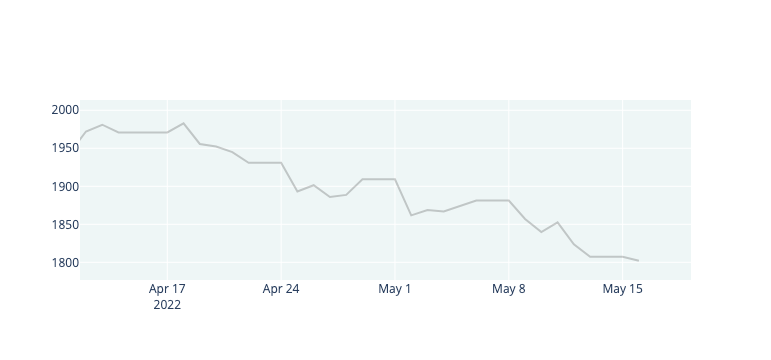

In [70]:
symbol = 'GC=F'
# create graph
title = 'Closing price ' + symbol

gdp_layout = go.Layout(
        height=300,
        #paper_bgcolor=COLORS[1],
        plot_bgcolor='#eef6f6',
        )

fig_gdp = go.Figure(layout=gdp_layout)
fig_gdp.add_trace(go.Scatter(x=gold_data.index, y=gold_data['Close'],
                    #text=ts_years,
                    mode='lines',
                    #name=c_,
                    opacity=.25,
                    marker=dict(color='#333333')
                    #visible='legendonly'
                    ))
fig_gdp.update_traces(showlegend=False)
    